In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

from IPython.display import HTML, display
import tabulate

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

# Modèle custom
## Charger les données

227


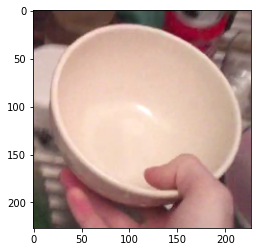

In [2]:
im = Image.open('../DB/test/Bowl/BowlPlace6Subject4_2_bboxes_157_0.png')
plt.imshow(im)
print(im.width)

In [3]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    '../DB/train', labels='inferred', label_mode='categorical',
    image_size=(im.width, im.height), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    '../DB/test', labels='inferred', label_mode='categorical',
    image_size=(im.width, im.height), shuffle=False, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 4736 files belonging to 5 classes.
Found 3568 files belonging to 5 classes.


## Data augmentation

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory('../DB/train', batch_size = 32, class_mode = 'categorical', target_size = (im.width, im.height))
test_generator = test_datagen.flow_from_directory('../DB/test', batch_size = 32, class_mode = 'categorical', target_size = (im.width, im.height))

Found 4736 images belonging to 5 classes.
Found 3568 images belonging to 5 classes.


## Créer un modèle

In [5]:
input_layer = tfl.Input((im.width, im.height, 3))

In [6]:
conv1 = tfl.Conv2D(32, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu')(input_layer)
m1 = tfl.MaxPool2D(pool_size=(2, 2), strides=2)(conv1)
conv2 = tfl.Conv2D(32, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu')(m1)
m2 = tfl.MaxPool2D(pool_size=(2, 2), strides=2)(conv2)
conv3 = tfl.Conv2D(64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu')(m2)
m3 = tfl.MaxPool2D(pool_size=(2, 2), strides=2)(conv3)
conv4 = tfl.Conv2D(64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu')(m3)

In [7]:
flat = tfl.Flatten()(conv4)
d1 = tfl.Dense(256, activation='relu')(flat)
d2 = tfl.Dense(128, activation='relu')(d1)
d3 = tfl.Dense(64, activation='relu')(d2)
out = tfl.Dense(5, activation='softmax')(d3)

In [8]:
model = Model(input_layer, out)

In [9]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 227, 227, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 113, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)       

In [10]:
logdir = "logs/monmodel"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
checkpoints = tf.keras.callbacks.ModelCheckpoint(
    '../models/best_models', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
    'accuracy', 
    'categorical_accuracy',
    tf.keras.metrics.Recall(),
    tf.keras.metrics.Precision()])

In [11]:
model.fit(train_generator, validation_data = test_generator, epochs=10, callbacks=[tensorboard_callback, checkpoints])

Epoch 1/10
  1/148 [..............................] - ETA: 0s - loss: 1.6037 - accuracy: 0.2188 - categorical_accuracy: 0.2188 - recall: 0.0000e+00 - precision: 0.0000e+00WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
148/148 [==============================] - ETA: 0s - loss: 1.0601 - accuracy: 0.5553 - categorical_accuracy: 0.5553 - recall: 0.3680 - precision: 0.7256WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as u

In [12]:
model.evaluate(test_generator)

112/112 [==============================] - 27s 243ms/step - loss: 0.0856 - accuracy: 0.9703 - categorical_accuracy: 0.9703 - recall: 0.9680 - precision: 0.9713


[0.08564036339521408,
 0.9702914953231812,
 0.9702914953231812,
 0.9680493474006653,
 0.9713160991668701]

## Sauvegarde du modèle

In [13]:
model.save('../models/custom_13_12_2020')

INFO:tensorflow:Assets written to: ../models/custom_13_12_2020/assets


## Matrice de confusion

In [23]:
model = tf.keras.models.load_model('../models/best_models', custom_objects=None, compile=True, options=None)

In [24]:
data_x = np.concatenate([x/255. for x, y in test], axis=0)
data_y = np.concatenate([y for x, y in test], axis=0)

In [25]:
pred = model.predict(data_x)

In [26]:
predictions = np.argmax(pred, axis=1)
labels = np.argmax(data_y, axis=1)

confusion = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        confusion[j, i] = np.sum(((predictions == i) & (labels == j)))

accuracy = np.diag(confusion).sum() / confusion.sum()

precision = 0
rappel = 0
for i in range(5):
    precision += (confusion[i, i] / np.sum(confusion[:, i]))
    rappel += (confusion[i, i] / np.sum(confusion[i, :]))

precision /= 5
rappel /= 5

f_score = 2 * ((precision * rappel) / (precision + rappel))

table = []
# display data
for i in range(5):
    line = []
    for j in range(5):
        line.append(confusion[i, j])
    table.append(line)

table = pd.DataFrame(table, index=range(5))
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=range(5))))

,0,1,2,3,4
0,556,0,9,0,0
1,5,655,1,0,10
2,2,0,634,6,0
3,20,0,27,830,0
4,0,8,6,12,787


In [27]:
metrics = pd.DataFrame([[accuracy], [precision], [rappel], [f_score]], index=['Accuracy', 'Precision', 'Recall', 'F-Score'])
display(HTML(tabulate.tabulate(metrics, tablefmt='html')))

Accuracy,0.970291
Precision,0.968866
Recall,0.972439
F-Score,0.970649


## Mauvaises prédictions

In [29]:
model = tf.keras.models.load_model('../models/best_models', custom_objects=None, compile=True, options=None)

In [30]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_generator = test_datagen.flow_from_directory('../DB/test', batch_size = 3568, class_mode = 'categorical', target_size = (im.width, im.height))

# On récupère les images d'un batch de la taille du dataset
i = 0
for image, y in test_generator:
    if i == 0: break # sinon le generator continue sa boucle (??)

Found 3568 images belonging to 5 classes.


In [31]:
# On fait la prédiction sur tous le set de test
bad_images = []
bad_labels = []

prediction = model.predict(image)
idx_pred = np.argmax(prediction, axis=1)
true = np.argmax(y, axis=1)

In [33]:
# on choisit un seuil
threshold = 0.9

# entrée dont la prédiction est supérieure au seuil
high_percentage = np.max(prediction, axis=1) > threshold
# entrées dont la prédiction de correspond pas au vrai label
bad_results = (idx_pred != true)
# On prend l'union des deux
indices = np.logical_and(high_percentage, bad_results)


bad = image[indices]
bad_pred = prediction[indices]

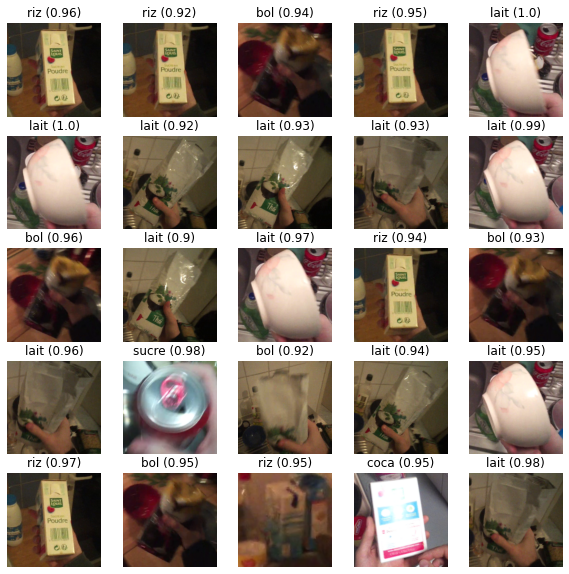

In [34]:
def display_images(images, lab, n_line, l_col):
    plt.figure(figsize=(10, 10))
    labels = { 0: 'bol', 1: 'coca', 2: 'lait', 3: 'riz', 4: 'sucre' }
    
    for i in range(n_line*l_col):
        ax = plt.subplot(n_line, l_col, i + 1)
        plt.imshow(images[i])
        idx = np.argmax(lab[i])
        plt.title(f'{labels[idx]} ({lab[i][idx]:.2})')
        plt.axis("off")

display_images(bad, bad_pred, 5, 5)